<a href="https://colab.research.google.com/github/SLCFLAB/Data-Science-Python/blob/main/Day%2015/15_1.%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

* 🧔🏻 G: 위조지폐 제작
* 👮🏻‍♀️ D: 위조지폐 판별 - G 실패
* 🧔🏻 G: 다시 위조지폐 제작
* 👮🏻‍♀️ D: 판별 실패 - G 성공

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [ ]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

In [ ]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

In [ ]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

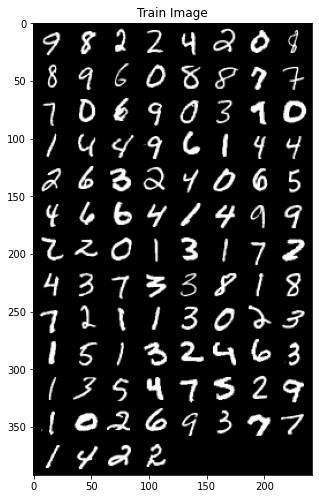

In [ ]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(250, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        out = self.discriminator(x)
        return out

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(100, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        out = self.generator(z)
        out = out.view(-1, 1, 28, 28)
        return out

In [ ]:
D = Discriminator().cuda()
G = Generator().cuda()

## Train

In [ ]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
        
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, target_tensor.cuda())

In [ ]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [ ]:
num_epochs = 50

In [ ]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
            
        # Discreminator
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = torch.randn((batch_size, 100)).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        # Generator
        z = torch.randn((batch_size, 100)).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/50], lter [100/600], D_Loss: 0.5402, G_Loss: 2.8887
Epoch [1/50], lter [200/600], D_Loss: 0.3439, G_Loss: 2.9135
Epoch [1/50], lter [300/600], D_Loss: 0.0804, G_Loss: 4.3266
Epoch [1/50], lter [400/600], D_Loss: 0.1018, G_Loss: 4.8875
Epoch [1/50], lter [500/600], D_Loss: 0.1314, G_Loss: 4.8174
Epoch [1/50], lter [600/600], D_Loss: 0.0667, G_Loss: 6.5272
Epoch [2/50], lter [100/600], D_Loss: 0.1000, G_Loss: 7.0174
Epoch [2/50], lter [200/600], D_Loss: 0.0553, G_Loss: 7.2198
Epoch [2/50], lter [300/600], D_Loss: 0.0314, G_Loss: 6.2067
Epoch [2/50], lter [400/600], D_Loss: 0.0199, G_Loss: 7.1870
Epoch [2/50], lter [500/600], D_Loss: 0.0420, G_Loss: 7.9621
Epoch [2/50], lter [600/600], D_Loss: 0.0309, G_Loss: 9.3993
Epoch [3/50], lter [100/600], D_Loss: 0.0253, G_Loss: 8.5195
Epoch [3/50], lter [200/600], D_Loss: 0.0135, G_Loss: 11.6974
Epoch [3/50], lter [300/600], D_Loss: 0.0342, G_Loss: 9.2480
Epoch [3/50], lter [400/600], D_Loss: 0.0300, G_Loss: 8.0444
Epoch [3/50], lter [500

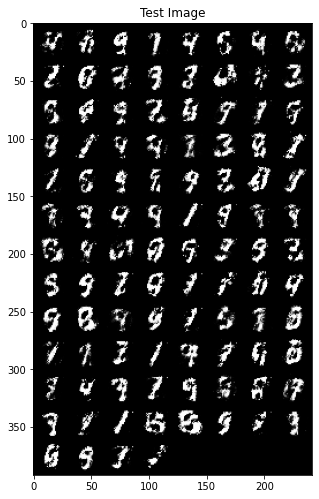

In [ ]:
G.eval()

z = torch.randn((batch_size, 100)).cuda()
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")